In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from itertools import combinations

## 1) Genetic Drift

In [128]:
class GeneticDriftModel:
    """
    Genetic drift model

    ...

    Attributes
    ----------
    N : int
        Population size
    p : proba
        Inital allele A frequency. 
    t : int
        Number of generations to simulate
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    genetic_drift_simulation(N, p, t):
        Run a genetic drift model simulation with given parameters

    estimate_simulation_parameters(N, p, t, nb_simulations):
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, p, t, nb_simulations):
        self.N = N
        self.p = p
        self.t = t
        self.nb_simulations = nb_simulations

    def genetic_drift_simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of haploid individuals.

        Returns
        -------
        A_freq : list of float between 0 and 1
            Allele A frequency at each generation t
        B_freq : list of float between 0 and 1
            Allele B frequency at each generation t
        """
        # Initialize population at time t=0
        # N haploid individual, with allele A frequency = p, and allele frequency B = 1-p
        nb_A = round(self.p * self.N)
        nb_B = self.N - nb_A
        population = np.concatenate((np.full(nb_A, 'A'), np.full(nb_B, 'B')))

        # Initialize allele frequencies, that will evolve through generations
        current_A_freq = self.p
        current_B_freq = 1 - self.p

        # Store all values of allele frequencies
        A_freq = [current_A_freq]
        B_freq = [current_B_freq]

        # parents_matrix(t, N) is the parent of allele N of gen t + 1
        parents_matrix = np.random.randint(self.N, size=(self.t, self.N))

        for generation in range(self.t):
            # Retrieve parents
            parents = parents_matrix[generation]
            # Generate gen t + 1
            population = population[parents]
            current_A_freq = np.sum(population=='A') / self.N
            current_B_freq = 1 - current_A_freq

            A_freq.append(current_A_freq)
            B_freq.append(current_B_freq)

        return A_freq, B_freq


    def estimate_simulation_parameters(self):
        """Run several simulations with same initialization parameters.
        Frequencies are then estimated from the outputs of all simulations
            
        Returns
        -------
        (freq_A_fixed, freq_B_fixed) : tuple of proba
            Frequency of allele A/allele B being fixed
        (avg_time_A_fixed, avg_time_B_fixed) : tuple of proba
            Average allele A/ allele B fixation time (in number of generations)
        (avg_A_freq, avg_B_freq) : tuple of list of proba
            For each generation, average allele A/ allele B frequency between all simulations
        """

        all_A_freq = []
        all_B_freq = []
        for simulation in range(self.nb_simulations):
            A_freq, B_freq = self.genetic_drift_simulation()
            all_A_freq.append(A_freq)
            all_B_freq.append(B_freq)

        # Get all simulations where A/B is fixed (ie. a frequency equals 1 or 0)
        sims_fixed_A_freq = [A_freq for A_freq in all_A_freq if (1 in A_freq) or (0 in A_freq)]
        sims_fixed_B_freq = [B_freq for B_freq in all_B_freq if (1 in B_freq) or (0 in B_freq)]

        # Compute frequencies of fixed simulations
        freq_A_fixed = len(sims_fixed_A_freq) / self.nb_simulations
        freq_B_fixed = len(sims_fixed_B_freq) / self.nb_simulations

        # Look for first generation where allele frequency is 1 or 0 within all fixed simulations
        time_A_fixed = [A_freq.index(1) if 1 in A_freq else A_freq.index(0) for A_freq in sims_fixed_A_freq]
        time_B_fixed = [B_freq.index(1) if 1 in B_freq else B_freq.index(0) for B_freq in sims_fixed_B_freq]

        # Compte average allele frequency at each generation
        avg_A_freq = np.mean(all_A_freq, axis=0)
        avg_B_freq = np.mean(all_B_freq, axis=0)

        # Compute average fixation time
        avg_time_A_fixed = np.mean(time_A_fixed) if time_A_fixed else 0
        avg_time_B_fixed = np.mean(time_B_fixed) if time_B_fixed else 0

        return (freq_A_fixed, freq_B_fixed), (avg_time_A_fixed, avg_time_B_fixed), (avg_A_freq, avg_B_freq)
    
    def update_p(self, new_p):
        self.p = new_p
    
    def update_N(self, new_N):
        self.N = new_N

    def update_t(self, new_t):
        self.t = new_t

### a) Allele frequency over time

To estimate the allele frequency over time, several simulations are run, and allele frequency is estimated with the empirical mean of allele frequency over all simulations

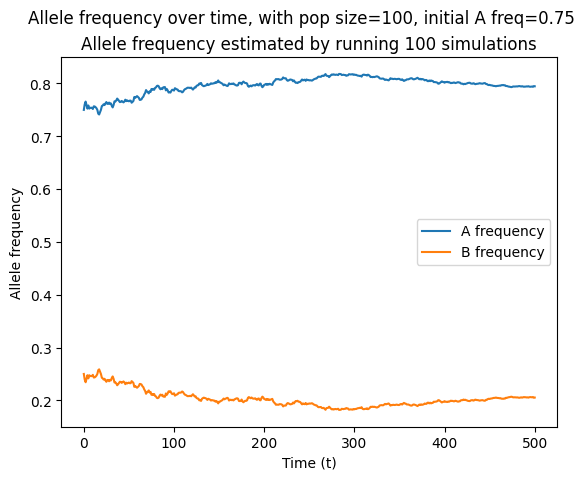

In [15]:
model = GeneticDriftModel(N=100, t=500, p=0.75, nb_simulations=100)

(freq_A_fixed, freq_B_fixed), _, (avg_A_freq, avg_B_freq) = model.estimate_simulation_parameters()
plt.plot(avg_A_freq, label="A frequency")
plt.plot(avg_B_freq, label="B frequency")
plt.legend()
plt.xlabel("Time (t)")
plt.ylabel("Allele frequency")
plt.suptitle(f"Allele frequency over time, with pop size={model.N}, initial A freq={model.p}")
plt.title(f"Allele frequency estimated by running {model.nb_simulations} simulations");

### Comparison with theorical results

We notice that expected allele frequency remains constant over time. This is not contradictory with the fact that allele frequency will at a moment, be 1 or 0. On the graphe above we see that allele A frequency remains constant at 0.7: this means that in 70% of simulations, allele A frequency will be 1, whereas it will be 0 in 30% of simulations.

If we look at several individual allele frequencies (not estimated from several simulations), we notice that is always fixed to 1 or 0:

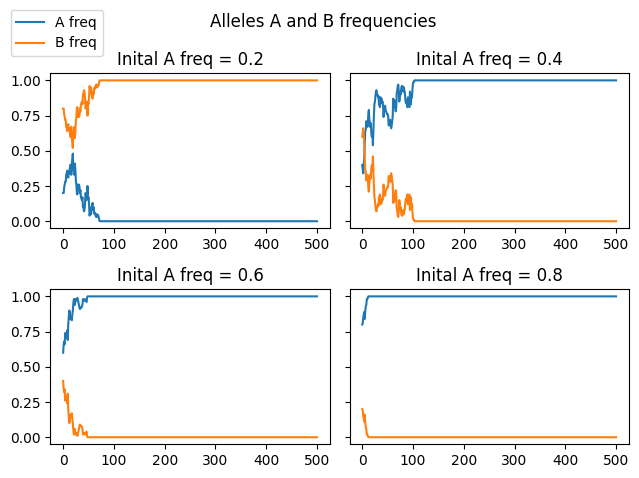

In [16]:
f, axes = plt.subplots(2, 2, sharey=True)
(sp1, sp2), (sp3, sp4) = axes[0], axes[1]
for p, sp in zip([0.2, 0.4, 0.6, 0.8], [sp1, sp2, sp3, sp4]):
    model.update_p(p)
    A_freq, B_freq = model.genetic_drift_simulation()
    sp.plot(A_freq, label="A freq")
    sp.plot(B_freq, label="B freq")
    sp.set_title(f"Inital A freq = {model.p}")
f.legend(["A freq", "B freq"], loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
f.suptitle("Alleles A and B frequencies")
f.tight_layout()

### b) Fixation probability of A depending on p

To estimate fixation probability, several simulations are run for 10 values of p : 0, 0.1, 0.2, ..., 0.9, 1. Then, the fixation probability is estimated with the frequency of allele A being fixed in all simulations run for the given value of p.

100%|██████████| 11/11 [00:03<00:00,  3.17it/s]


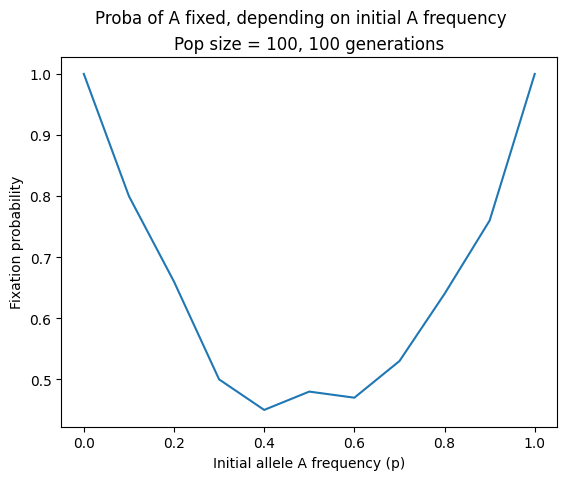

In [129]:
all_proba_A_fixed = []
all_proba_B_fixed = []
p_values = np.round(np.linspace(0, 1, 11), 1)
model.update_t(100)
for p in tqdm(p_values):
    model.update_p(p)
    (freq_A_fixed, _), _, _ = model.estimate_simulation_parameters()
    all_proba_A_fixed.append(freq_A_fixed)
    
plt.plot(p_values, all_proba_A_fixed, label="Proba A fixed")
plt.xlabel("Initial allele A frequency (p)")
plt.ylabel("Fixation probability")
plt.suptitle("Proba of A fixed, depending on initial A frequency");
plt.title(f"Pop size = {model.N}, {model.t} generations");

### Comparison with theorical results

We notice that if the original allele A frequency is above 0.5, the fixation probability is equal to the frequency of A in gen t=0. If the frequency of A in gen t=0 is below 0.5, the fixation probability is 1 - frequncy of A in t=0 = frequency of B in t=0.

We proved in class that p will, at a moment, always be 0 or 1: it means that the fixation probability converges to 1. Thus, if we run this simulation for more generations, we should see that the fixation probability of allele A is 1.

100%|██████████| 11/11 [00:36<00:00,  3.31s/it]


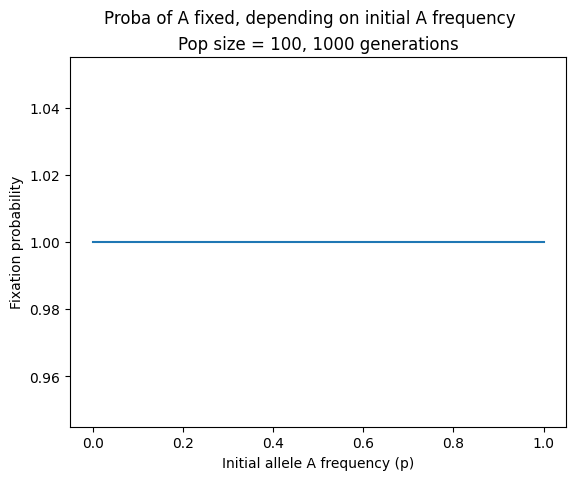

In [18]:
all_proba_A_fixed = []
all_proba_B_fixed = []
p_values = np.round(np.linspace(0, 1, 11), 1)
model.update_t(1000)
for p in tqdm(p_values):
    model.update_p(p)
    (freq_A_fixed, _), _, _ = model.estimate_simulation_parameters()
    all_proba_A_fixed.append(freq_A_fixed)
    
plt.plot(p_values, all_proba_A_fixed, label="Proba A fixed")
plt.xlabel("Initial allele A frequency (p)")
plt.ylabel("Fixation probability")
plt.suptitle("Proba of A fixed, depending on initial A frequency");
plt.title(f"Pop size = {model.N}, {model.t} generations");

While running simulation on 1000 generations instead 100, we indeed see that the fixation probability is 1.

### c) Expected fixation time in dependence of N

To estimate fixation time, several simulations are run for 20 values of N : 50, 100, 150, ..., 950, 1000. Then, the fixation time is estimated with the average fixation time over all simulations run for the given value of N.

100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


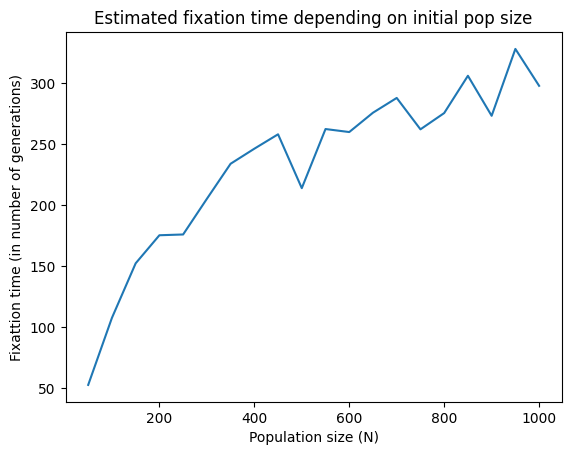

In [19]:
model.update_p(0.75)
model.update_t(500)

all_time_A_fixed = []
all_time_B_fixed = []
N_values = np.round(np.linspace(50, 1000, 20), 1).astype(int)
for N in tqdm(N_values):
    model.update_N(N)
    _, (avg_time_A_fixed, _), _ = model.estimate_simulation_parameters()
    all_time_A_fixed.append(avg_time_A_fixed)
    
plt.plot(N_values, all_time_A_fixed, label="Time A fixed")
plt.xlabel("Population size (N)")
plt.ylabel("Fixattion time (in number of generations)")
plt.title("Estimated fixation time depending on initial pop size");

### Comparison with theorical results


## 2) Coalescent model

## 3) Mutations in the infinite-allele model

To simulate mutations, we encode all allele A by 1, all allele B by -1. Everytime an allele mutates, the allele will be encoded with 0. Since every mutation creates a unique allele, and the goal is only to compute the fixation index, only alleles with no mutation can be identical.

In [20]:
class MutationModel:
    """
    Mutation model

    ...

    Attributes
    ----------
    N : int
        Population size
    p : proba
        Inital allele A frequency. 
    u : proba
        Mutation rate
    t : int
        Number of generations to simulate
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    mutations_simulation(N, p, u, t):
        Run a mutation model simulation with given parameters

    estimate_simulation_parameters(N, p, t, nb_simulations):
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, p, u, t, nb_simulations):
        self.N = N
        self.p = p
        self.u = u
        self.t = t
        self.nb_simulations = nb_simulations
        self.theta = 2 * self.u * self.N
        self.f_eq = 1 / (1 + self.theta)
        # All possible pairs of alleles. Will be used for Fixation Index
        self.idx_couples = np.array(list(combinations(range(self.N), 2)))


    def get_fixation_index(self, population):
        """Estimate the fixation index on a given population
        """

        # 1 - Retrieve all possible pair of alleles
        allele_pairs = population[self.idx_couples]

        # 2 - Get identical alleles
        identical_alleles = allele_pairs[allele_pairs[:, 0] == allele_pairs[:, 1]]
        # Remove mutated alleles
        identical_alleles = identical_alleles[identical_alleles[:, 0] != "M"]

        # 3 - Compute fixation index
        fixation_index = len(identical_alleles) / len(self.idx_couples)

        return fixation_index
    

    def initialize_population(self):
        """Initialize population at time t = 0
        """

        # N haploid individual, with allele A frequency = p, and allele frequency B = 1-p
        nb_A = round(self.p * self.N)
        nb_B = self.N - nb_A
        # Create population of size N, with alleles A and B on random individuals
        population = np.concatenate((np.full(nb_A, "A"), np.full(nb_B, "B")))
        return population

    def mutations_simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of haploid individuals,
        with mutation

        Parameters
        ----------
        N : int
            Population size
        p : proba
            Inital allele A frequency. 
        u : proba
            Probability that an allele mutates in each generation
        t : int
            Number of generations to simulate

        Returns
        -------
        population_evolution : list of lists
            Each sublist describes the population at time t
            Sublists is composed of 1 (allele A), -1 (allele B), and 0 (mutated allele)
        fixation indexes : list of proba
            Contains computed fixation index at each generation
        """
        population = self.initialize_population()

        # mutation_matrix contains the realisations of a random variable following N([0, 1])
        # Thus, allele N in generation t mutates if mutation_matrix(t, n) < u
        mutation_matrix = np.random.rand(self.t, self.N)

        # parents_matrix(t, N) is the parent of allele N of gen t + 1
        parents_matrix = np.random.randint(self.N, size=(self.t, self.N))

        # Store populations and fixation indexes for all generations
        population_evolution = [population]
        fixation_indexes = [self.get_fixation_index(population)]

        for generation in range(self.t):
            # Retrieve genes that mutates
            mutated_alleles_index = np.where(mutation_matrix[generation] < self.u)
            population[mutated_alleles_index] = "M"

            # Retrieve parents of pop t+1
            parents = parents_matrix[generation]
            
            # Generate population t+1 with selected parents
            population = population[parents]
            population_evolution.append(population)

            # Compute fixation index for gen t+1
            fixation_index = self.get_fixation_index(population)
            fixation_indexes.append(fixation_index)
        
        return population_evolution, fixation_indexes


    def estimate_fixation_index(self):
        """
        Run several simulations with same initialization parameters.
        Frequencies are then estimated from the outputs of all simulations

        Returns
        -------
        avg_fixation_indexes : list of proba
            Contains computed fixation index at each generation. 
            Fixation indexes are estimated over all simulations.
        """
        all_fixation_indexes = []
        for simulation in tqdm(range(self.nb_simulations)):
            _, fixation_indexes = self.mutations_simulation()
            all_fixation_indexes.append(fixation_indexes)

        avg_fixation_indexes = np.mean(all_fixation_indexes, axis=0)
        return avg_fixation_indexes


    def theorical_fixation_index(self):
        """
        Compute fixation index from theorical results

        Returns
        -------
        fixation_indexes : list of proba
            Contains computed fixation index at each generation. 
        """
    
        population = self.initialize_population()

        fixation_index = self.get_fixation_index(population)
        fixation_indexes = [fixation_index]
        for generation in range(self.t):
            fixation_index = (1/self.N)*(1 - self.u)**2 + fixation_index*(1 - 1/self.N)*(1 - self.u)**2
            fixation_indexes.append(fixation_index)
        return fixation_indexes

    def update_u(self, new_u):
        self.u = new_u
        self.theta = 2 * self.N * self.u
        self.f_eq = 1 / (1 + self.theta)

    def update_N(self, new_N):
        self.N = new_N
        self.idx_couples = np.array(list(combinations(range(self.N), 2)))
        self.theta = 2 * self.N * self.u
        self.f_eq = 1 / (1 + self.theta)


### Comparison with theorical results

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


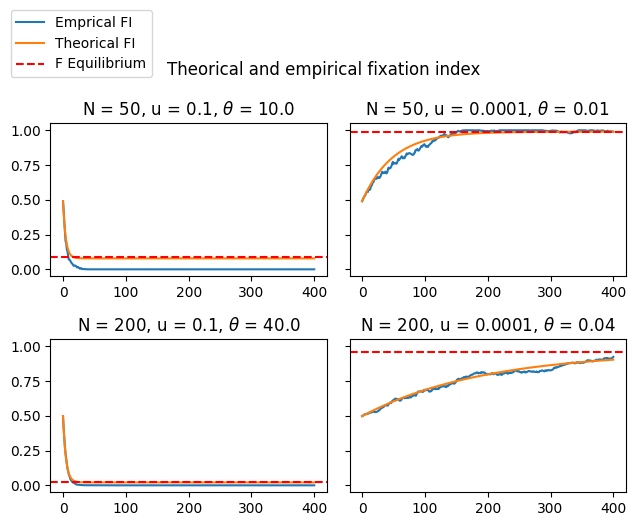

In [21]:
N = 100 # Population size
p = 0.5 # Initial allele A frequency
u = 0.1 # mutation rate
t = 400 # Number of generations
model_mutation = MutationModel(N, p, u, t, 30)

f, axes = plt.subplots(2, 2, sharey=True)
(sp1, sp2), (sp3, sp4) = axes[0], axes[1]
N_values = [50, 50, 200, 200]
u_values = [0.1, 0.0001, 0.1, 0.0001]
for N, u, sp in zip(N_values, u_values, [sp1, sp2, sp3, sp4]):
    model_mutation.update_N(N)
    model_mutation.update_u(u)
    avg_fixation_indexes = model_mutation.estimate_fixation_index()
    true_fixation_indexes = model_mutation.theorical_fixation_index()
    sp.plot(avg_fixation_indexes)
    sp.plot(true_fixation_indexes)
    sp.axhline(y=model_mutation.f_eq, color="red", linestyle="--", label=f"y = {model_mutation.f_eq}")
    sp.set_title(rf"N = {model_mutation.N}, u = {model_mutation.u}, $\theta$ = {model_mutation.theta}")
f.legend(["Emprical FI", "Theorical FI", "F Equilibrium"], loc='upper left', bbox_to_anchor=(0, 1.1), ncol=1)
f.suptitle("Theorical and empirical fixation index")
f.tight_layout()

## 4) Selection

In [64]:
class FitnessModel:
    """
    Fitness model

    ...

    Attributes
    ----------
    N : int
        Population size
    p : proba
        Inital allele A frequency. 
    w : float
        1 + w is fitness of B, while 1 is fitness of A
    t : int
        Number of generations to simulate
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    genetic_drift_simulation(N, p, t):
        Run a genetic drift model simulation with given parameters

    estimate_simulation_parameters(N, p, t, nb_simulations):
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, p, w, t, nb_simulations):
        self.N = N
        self.p = p
        self.t = t
        self.w = w
        self.nb_simulations = nb_simulations

    def fitness_simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of diploid individuals.

        Returns
        -------
        A_freq : list of float between 0 and 1
            Allele A frequency at each generation t
        B_freq : list of float between 0 and 1
            Allele B frequency at each generation t
        """
        # Initialize population at time t=0
        # N diploid individual, with allele A frequency = p, and allele frequency B = 1-p

        # allele frequencies  change at each generation
        current_N = 2 * self.N
        current_A_freq = self.p
        current_B_freq = 1 - self.p

        # Store values of allele frequencies at each generation
        A_freq = [current_A_freq]
        B_freq = [current_B_freq]

        for generation in range(self.t):
            # Generate probability for all allele in the population
            proba_parents_A, proba_parents_B = np.random.rand(2, current_N)

            # Proba of chosing B is proportionnal to fitness
            parents_A = np.sum(proba_parents_A <= current_A_freq)
            parents_B = np.sum(proba_parents_B <= current_B_freq * (1 + self.w))

            current_N = parents_A + parents_B
            current_A_freq = parents_A / current_N
            current_B_freq = parents_B / current_N

            A_freq.append(current_A_freq)
            B_freq.append(current_B_freq)
        
        return A_freq, B_freq


    def estimate_simulation_parameters(self):
        """Run several simulations with same initialization parameters.
        Frequencies are then estimated from the outputs of all simulations
            
        Returns
        -------
        (avg_A_freq, avg_B_freq) : tuple of list of proba
            For each generation, average allele A/ allele B frequency between all simulations
        avg_N : int
            For each generation, the average population size
        """

        all_A_freq = []
        all_B_freq = []
        for simulation in range(self.nb_simulations):
            A_freq, B_freq = self.fitness_simulation()
            all_A_freq.append(A_freq)
            all_B_freq.append(B_freq)

        # Compte average allele frequency at each generation
        avg_A_freq = np.mean(all_A_freq, axis=0)
        avg_B_freq = np.mean(all_B_freq, axis=0)

        return (avg_A_freq, avg_B_freq)
    
    def theorical_frequencies(self):
        # Initialize population at time t=0
        # N diploid individual, with allele A frequency = p, and allele frequency B = 1-p
        nb_A = round(self.p * self.N * 2)
        nb_B = 2 * self.N - nb_A

        all_nb_B = (np.full(self.t, (1 + self.w)) ** range(self.t)) * nb_B
        all_nb_A = np.full(self.t, nb_A)
        all_N = all_nb_A + all_nb_B

        true_A_freq = all_nb_B / all_N
        true_B_freq = all_nb_B / all_N

        return (true_A_freq, true_B_freq)
    
    def update_p(self, new_p):
        self.p = new_p
    
    def update_N(self, new_N):
        self.N = new_N

    def update_w(self, new_w):
        self.w = new_w

6it [00:01,  3.36it/s]


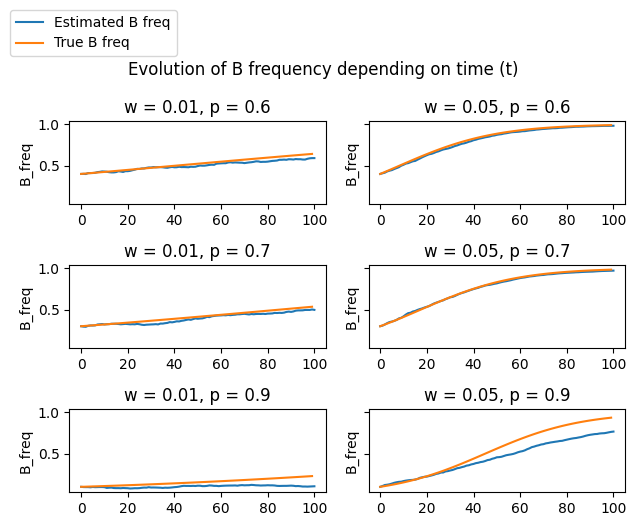

In [65]:
N = 100 # Population size
p = 0.5 # Initial allele A frequency
w = 0.1 # fitness
t = 100 # Number of generations
model_fitness = FitnessModel(N, p, w, t, 30)

f, axes = plt.subplots(3, 2, sharey=True)
(sp1, sp2), (sp3, sp4), (sp5, sp6) = axes[0], axes[1], axes[2]
p_values = [0.6, 0.6, 0.7, 0.7, 0.9, 0.9]
w_values = [0.01, 0.05, 0.01, 0.05, 0.01, 0.05]
for p, w, sp in tqdm(zip(p_values, w_values, [sp1, sp2, sp3, sp4, sp5, sp6])):
    model_fitness.update_p(p)
    model_fitness.update_w(w)
    (avg_A_freq, avg_B_freq) = model_fitness.estimate_simulation_parameters()
    (true_A_freq, true_B_freq) = model_fitness.theorical_frequencies()
    sp.plot(avg_B_freq)
    sp.plot(true_B_freq)
    sp.set_ylabel("B_freq")
    sp.set_title(rf"w = {model_fitness.w}, p = {model_fitness.p}")
f.legend(["Estimated B freq", "True B freq"], loc='upper left', bbox_to_anchor=(0, 1.1))
f.suptitle("Evolution of B frequency depending on time (t)")
f.tight_layout()

## Question 5)

In [66]:
class ClonalInterferenceModel:
    """
    Clonal Interference model

    ...

    Attributes
    ----------
    N : int
        Population size
    t : int
        Number of generations to simulate
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    genetic_drift_simulation(N, p, t):
        Run a genetic drift model simulation with given parameters

    estimate_simulation_parameters(N, p, t, nb_simulations):
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, t, nb_simulations):
        self.N = N
        self.t = t
        self.pA = 0.79
        self.pB = 0.2
        self.pC = 0.01
        self.wA = 0
        self.wB = 0.05
        self.wC = 0.1
        self.nb_simulations = nb_simulations

    def fitness_simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of diploid individuals.

        Returns
        -------
        A_freq : list of float between 0 and 1
            Allele A frequency at each generation t
        B_freq : list of float between 0 and 1
            Allele B frequency at each generation t
        C_freq : list of float between 0 and 1
            Allele B frequency at each generation t
        """
        # Initialize population at time t=0
        # N diploid individual, with allele A frequency = p, and allele frequency B = 1-p

        # allele frequencies  change at each generation
        current_N = 2 * self.N
        current_A_freq = self.pA
        current_B_freq = self.pB
        current_C_freq = self.pC

        # Store values of allele frequencies at each generation
        A_freq = [current_A_freq]
        B_freq = [current_B_freq]
        C_freq = [current_C_freq]

        for generation in range(self.t):
            # Generate probability for all allele in the population
            proba_parents_A, proba_parents_B, proba_parents_C = np.random.rand(3, current_N)

            parents_A = np.sum(proba_parents_A <= current_A_freq)
            parents_B = np.sum(proba_parents_B <= current_B_freq * (1 + self.wB))
            parents_C = np.sum(proba_parents_C <= current_C_freq * (1 + self.wC))

            current_N = parents_A + parents_B + parents_C
            current_A_freq = parents_A / current_N
            current_B_freq = parents_B / current_N
            current_C_freq = parents_C / current_N

            A_freq.append(current_A_freq)
            B_freq.append(current_B_freq)
            C_freq.append(current_C_freq)
        
        return A_freq, B_freq, C_freq


    def estimate_simulation_parameters(self):
        """Run several simulations with same initialization parameters.
        Frequencies are then estimated from the outputs of all simulations
            
        Returns
        -------
        (avg_A_freq, avg_B_freq) : tuple of list of proba
            For each generation, average allele A/ allele B frequency between all simulations
        avg_N : int
            For each generation, the average population size
        """

        all_A_freq = []
        all_B_freq = []
        all_C_freq = []
        for simulation in range(self.nb_simulations):
            A_freq, B_freq, C_freq = self.fitness_simulation()
            all_A_freq.append(A_freq)
            all_B_freq.append(B_freq)
            all_C_freq.append(C_freq)

        # Compte average allele frequency at each generation
        avg_A_freq = np.mean(all_A_freq, axis=0)
        avg_B_freq = np.mean(all_B_freq, axis=0)
        avg_C_freq = np.mean(all_C_freq, axis=0)

        return (avg_A_freq, avg_B_freq, avg_C_freq)
    
    def theorical_frequencies(self):
        # Initialize population at time t=0
        # N diploid individual, with allele A freq = pA, allele B freq = pB, allele C freq = pC
        nb_A = round(self.pA * self.N * 2)
        nb_B = round(self.pB * self.N * 2)
        nb_C = 2 * self.N - (nb_A + nb_B)

        all_nb_A = (np.full(self.t, (1 + self.wA)) ** range(self.t)) * nb_A
        all_nb_B = (np.full(self.t, (1 + self.wB)) ** range(self.t)) * nb_B
        all_nb_C = (np.full(self.t, (1 + self.wC)) ** range(self.t)) * nb_C

        all_N = all_nb_A + all_nb_B + all_nb_C
        true_A_freq = all_nb_A / all_N
        true_B_freq = all_nb_B / all_N
        true_C_freq = all_nb_C / all_N

        return (true_A_freq, true_B_freq, true_C_freq)
    
    def update_p(self, new_p):
        self.p = new_p
    
    def update_N(self, new_N):
        self.N = new_N

    def update_w(self, new_w):
        self.w = new_w

### Comparison with theorical results

4it [00:28,  7.01s/it]


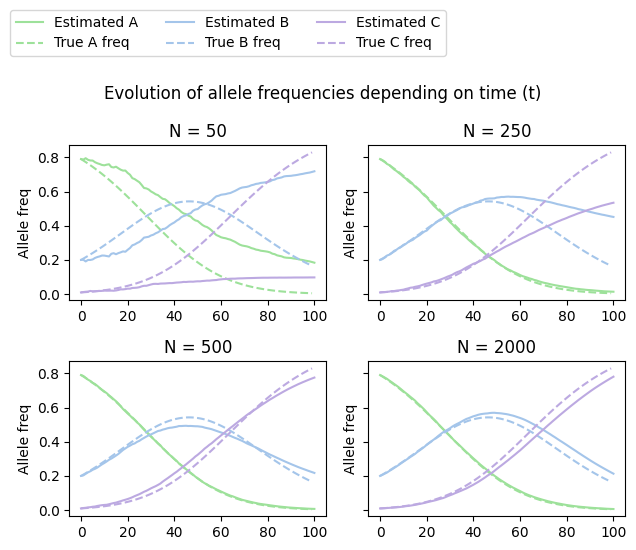

In [147]:
N = 100 # Population size
t = 100 # Number of generations
model_clonal = ClonalInterferenceModel(N, t, nb_simulations=30)

f, axes = plt.subplots(2, 2, sharey=True)
(sp1, sp2), (sp3, sp4) = axes[0], axes[1]
N_values = [50, 250, 500, 2000]
for N, sp in tqdm(zip(N_values, [sp1, sp2, sp3, sp4])):
    model_clonal.update_N(N)
    (avg_A_freq, avg_B_freq, avg_C_freq) = model_clonal.estimate_simulation_parameters()
    (true_A_freq, true_B_freq, true_C_freq) = model_clonal.theorical_frequencies()
    sp.plot(avg_A_freq, color="#9de19a")
    sp.plot(true_A_freq, color="#9de19a", linestyle="--")
    sp.plot(avg_B_freq, color="#a4c5ea")
    sp.plot(true_B_freq, color="#a4c5ea", linestyle="--")
    sp.plot(avg_C_freq, color="#bca9e1")
    sp.plot(true_C_freq, color="#bca9e1", linestyle="--")
    sp.set_ylabel("Allele freq")
    sp.set_title(rf"N = {model_clonal.N}")
f.legend(["Estimated A", "True A freq", "Estimated B", "True B freq", "Estimated C", "True C freq"],
         loc='upper left', bbox_to_anchor=(0, 1.15), ncols=3)
f.suptitle("Evolution of allele frequencies depending on time (t)")
f.tight_layout()

In [ ]:
N = 100 # Population size
t = 100 # Number of generations
model_clonal = ClonalInterferenceModel(N, t, nb_simulations=30)

f, axes = plt.subplots(2, 2, sharey=True)
(sp1, sp2), (sp3, sp4) = axes[0], axes[1]
N_values = [50, 250, 500, 2000]
for N, sp in tqdm(zip(N_values, [sp1, sp2, sp3, sp4])):
    model_clonal.update_N(N)
    (avg_A_freq, avg_B_freq, avg_C_freq) = model_clonal.estimate_simulation_parameters()
    (true_A_freq, true_B_freq, true_C_freq) = model_clonal.theorical_frequencies()
    sp.plot(avg_A_freq, color="#9de19a")
    sp.plot(true_A_freq, color="#9de19a", linestyle="--")
    sp.plot(avg_B_freq, color="#a4c5ea")
    sp.plot(true_B_freq, color="#a4c5ea", linestyle="--")
    sp.plot(avg_C_freq, color="#bca9e1")
    sp.plot(true_C_freq, color="#bca9e1", linestyle="--")
    sp.set_ylabel("Allele freq")
    sp.set_title(rf"N = {model_clonal.N}")
f.legend(["Estimated A", "True A freq", "Estimated B", "True B freq", "Estimated C", "True C freq"],
         loc='upper left', bbox_to_anchor=(0, 1.15), ncols=3)
f.suptitle("Evolution of allele frequencies depending on time (t)")
f.tight_layout()

In [159]:
N = 2000 # Population size
t = 120 # Number of generations
model_clonal = ClonalInterferenceModel(N, t, nb_simulations=30)

(avg_A_freq, avg_B_freq, avg_C_freq) = model_clonal.estimate_simulation_parameters()
(true_A_freq, true_B_freq, true_C_freq) = model_clonal.theorical_frequencies()

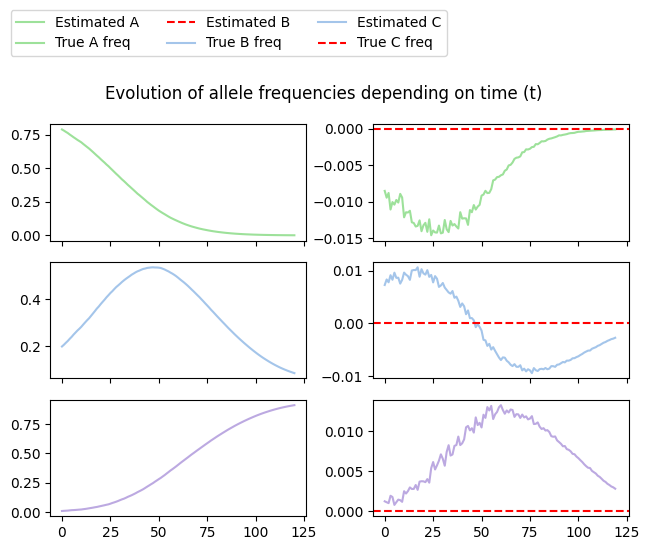

In [161]:
f, axes = plt.subplots(3, 2, sharex=True)
(sp1, sp2), (sp3, sp4), (sp5, sp6) = axes[0], axes[1], axes[2]
sp1.plot(avg_A_freq, color="#9de19a")
delta_A_freq = [avg_A_freq[i] - avg_A_freq[i-1] for i in range(1, len(avg_A_freq))]
sp2.plot(delta_A_freq, color="#9de19a")
sp2.axhline(y=0, color="red", linestyle="--")

sp3.plot(avg_B_freq, color="#a4c5ea")
delta_B_freq = [avg_B_freq[i] - avg_B_freq[i-1] for i in range(1, len(avg_B_freq))]
sp4.plot(delta_B_freq, color="#a4c5ea")
sp4.axhline(y=0, color="red", linestyle="--")

sp5.plot(avg_C_freq, color="#bca9e1")
delta_C_freq = [avg_C_freq[i] - avg_C_freq[i-1] for i in range(1, len(avg_C_freq))]
sp6.plot(delta_C_freq, color="#bca9e1")
sp6.axhline(y=0, color="red", linestyle="--")

f.legend(["Estimated A", "True A freq", "Estimated B", "True B freq", "Estimated C", "True C freq"],
        loc='upper left', bbox_to_anchor=(0, 1.15), ncols=3)
f.suptitle("Evolution of allele frequencies depending on time (t)")
f.tight_layout()

## 6) Population Structure

In [301]:
import random
import copy

class PopulationModel:
    """
    Population Structure model

    ...

    Attributes
    ----------
    N : int
        Population size
    p : proba
        Inital allele A frequency. 
    t : int
        Number of generations to simulate
    m : proba
        percentage of migration
    nb_sub_pop : int
        Number of sub populations
    nb_simulations : int
        Number of simulations to do to estimate frequencies

    Methods
    -------
    genetic_drift_simulation(N, p, t):
        Run a genetic drift model simulation with given parameters

    estimate_simulation_parameters(N, p, t, nb_simulations):
        Run several simulations to estimate frequencies
    """

    def __init__(self, N, p, t, m, nb_sub_pop, nb_simulations):
        self.N = N
        self.p = p
        self.t = t
        self.m = m
        self.nb_simulations = nb_simulations
        self.nb_sub_pop = nb_sub_pop
        self.subpop_size, _ = divmod(self.N, self.nb_sub_pop)
        self.migration_size = round(self.m * (self.N / self.nb_sub_pop))

    def initialize_population(self):
        subpop_size, remainder = divmod(self.N, self.nb_sub_pop)
        print(f"Pop size changed from {self.N} to {self.N - remainder} for simulation purposes")
        self.N = self.N - remainder

        nb_A_subpop = round(self.p * subpop_size)
        nb_B_subpop = subpop_size - nb_A_subpop
        print(nb_A_subpop, nb_B_subpop)
        print(np.concatenate((np.full(nb_A_subpop, 'A'), np.full(nb_B_subpop, 'B'))))
        populations = [
            np.concatenate((np.full(nb_A_subpop, 'A'), np.full(nb_B_subpop, 'B')))
            for _ in range(self.nb_sub_pop)
        ]
        for subpop in populations:
            np.random.shuffle(subpop)
        print(populations)

        # sanity check
        assert sum([len(subpop) for subpop in populations]) == self.N
        return populations
    

    def get_subpops_migration_towards(self):
        """ Generate, for each subpopulation, the other subpopulation towards migration is done.
        Simulating the migration "towards" for all subpopulation implies that all migrations "from"
        are also simulated.

        A subpop cannot migrate towards itself

        Migration directions list has to be understood this way:
            - for i, j in enumerate(migration_towards): sub_pop i migrates towards sub_pop j
            / or sub_pop j receice migration from sub_pop i
        Thus, the list is of size nb_subpop, and contains integers in range(nb_subpop).

        Returns
        -------
        all_migration_towards : list of lists
            Contains the migration_towards list for each generation

        """

        all_migration_towards = []
        for generation in range(self.t):
            migration_towards = list(range(self.nb_sub_pop))

            # A population cannot migrate towards itself
            while True in [i == subpop for i, subpop in enumerate(migration_towards)]:
                random.shuffle(migration_towards)

            all_migration_towards.append(migration_towards)

        return all_migration_towards
        

    def genetic_drift_simulation(self):
        """
        Simulate evolution of 2 alleles A and B in a population of haploid individuals.

        Returns
        -------
        A_freq : list of float between 0 and 1
            Allele A frequency at each generation t
        B_freq : list of float between 0 and 1
            Allele B frequency at each generation t
        """
        # Initialize population at time t=0
        # N haploid individual, with allele A frequency = p, and allele frequency B = 1-p
        # Population divided in 10 sub-populations
        populations = self.initialize_population()

        # Initialize allele frequencies, that will evolve through generations
        current_A_freq = self.p
        current_B_freq = 1 - self.p

        # Store all values of allele frequencies
        A_freq = [current_A_freq]
        B_freq = [current_B_freq]

        # Retrieve size of each subpopulation

        # parents_matrix(t, N) is the parent of allele N of gen t + 1
        # Thus, parents_matrix_list[s] is the parent matrix for subpopulation nb s
        parents_matrix_list = [np.random.randint(self.subpop_size, size=(self.t, self.subpop_size)) for _ in populations]

        if self.m:
            # Retrieve, for each generation and subpopulation, the subpopulation towards migratation is done
            all_migrations_towards = self.get_subpops_migration_towards()
            
            # Randomly chose alleles that will migrate
            # At each generation, the same alleles will migrate in all subpopulations
            # Thus, alleles_migrate[t, a] is the alleles index that migrates for generation t
            alleles_migrate = np.array([np.sort(np.random.choice(self.subpop_size, size=self.migration_size, replace=False)) for _ in range(self.t)])

        for generation in range(self.t):
            print(f"Generation {generation}\n")
            if self.m:
                populations_tmp = copy.deepcopy(populations)
                migrations_towards = all_migrations_towards[generation]
                alleles_migrate_index = alleles_migrate[generation]

                for i, subpop in enumerate(populations):
                    populations[migrations_towards[i]][alleles_migrate_index] = subpop[alleles_migrate_index]


            # Retrieve parents for each subpop
            all_parents = [parents_matrix[generation] for parents_matrix in parents_matrix_list]

            # Update subpops based on selected parents
            populations = [sub_population[parents] for sub_population, parents in zip(populations, all_parents)]

            # Count A in all subpops
            nb_A_subpops = [np.sum(sub_population=="A") for sub_population in populations]

            # Compute new A and B frequencies
            current_A_freq = sum(nb_A_subpops) / self.N
            current_B_freq = 1 - current_A_freq

            A_freq.append(current_A_freq)
            B_freq.append(current_B_freq)

        return A_freq, B_freq


    def estimate_simulation_parameters(self):
        """Run several simulations with same initialization parameters.
        Frequencies are then estimated from the outputs of all simulations
            
        Returns
        -------
        (freq_A_fixed, freq_B_fixed) : tuple of proba
            Frequency of allele A/allele B being fixed
        (avg_time_A_fixed, avg_time_B_fixed) : tuple of proba
            Average allele A/ allele B fixation time (in number of generations)
        (avg_A_freq, avg_B_freq) : tuple of list of proba
            For each generation, average allele A/ allele B frequency between all simulations
        """

        all_A_freq = []
        all_B_freq = []
        for simulation in range(self.nb_simulations):
            A_freq, B_freq = self.genetic_drift_simulation()
            all_A_freq.append(A_freq)
            all_B_freq.append(B_freq)

        # Get all simulations where A/B is fixed (ie. a frequency equals 1 or 0)
        sims_fixed_A_freq = [A_freq for A_freq in all_A_freq if (1 in A_freq) or (0 in A_freq)]
        sims_fixed_B_freq = [B_freq for B_freq in all_B_freq if (1 in B_freq) or (0 in B_freq)]

        # Compute frequencies of fixed simulations
        freq_A_fixed = len(sims_fixed_A_freq) / self.nb_simulations
        freq_B_fixed = len(sims_fixed_A_freq) / self.nb_simulations

        # Look for first generation where allele frequency is 1 or 0 within all fixed simulations
        time_A_fixed = [A_freq.index(1) if 1 in A_freq else A_freq.index(0) for A_freq in sims_fixed_A_freq]
        time_B_fixed = [B_freq.index(1) if 1 in B_freq else B_freq.index(0) for B_freq in sims_fixed_B_freq]

        # Compte average allele frequency at each generation
        avg_A_freq = np.mean(all_A_freq, axis=0)
        avg_B_freq = np.mean(all_B_freq, axis=0)

        # Compute average fixation time
        avg_time_A_fixed = np.mean(time_A_fixed) if time_A_fixed else 0 # 0 if fixation is never reached
        avg_time_B_fixed = np.mean(time_B_fixed) if time_B_fixed else 0

        return (freq_A_fixed, freq_B_fixed), (avg_time_A_fixed, avg_time_B_fixed), (avg_A_freq, avg_B_freq)
    
    def update_p(self, new_p):
        self.p = new_p
    
    def update_N(self, new_N):
        self.N = new_N

    def update_t(self, new_t):
        self.t = new_t

3it [00:05,  1.74s/it]


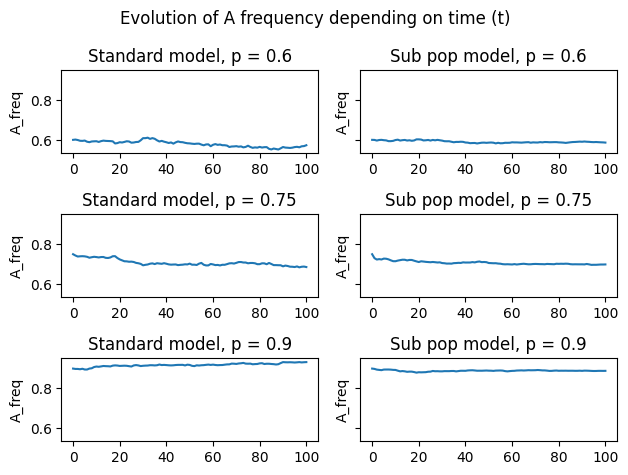

In [207]:

model_sub_pop = PopulationModel(N=300, t=100, p=0.8, m=None, nb_sub_pop=10, nb_simulations=50)
model = GeneticDriftModel(N=300, t=100, p=0.8, nb_simulations=50)

f, axes = plt.subplots(3, 2, sharey=True)
p_values = [0.6, 0.75, 0.9]

for p, ax in tqdm(zip(p_values, axes)):
    sp1, sp2 = ax
    model.update_p(p)
    model_sub_pop.update_p(p)
    _, _, (avg_A_freq, avg_B_freq) = model.estimate_simulation_parameters()
    _, _, (avg_A_freq_sp, avg_B_freq_sp) = model_sub_pop.estimate_simulation_parameters()

    sp1.plot(avg_A_freq)
    sp2.plot(avg_A_freq_sp)
    sp1.set_ylabel("A_freq")
    sp2.set_ylabel("A_freq")
    sp1.set_title(f"Standard model, p = {model.p}")
    sp2.set_title(f"Sub pop model, p = {model_sub_pop.p}")
f.suptitle("Evolution of A frequency depending on time (t)")
f.tight_layout()


In [280]:
a = ['a']
b = a.copy()
b[0] = 1
a

['a']

3it [00:01,  2.09it/s]


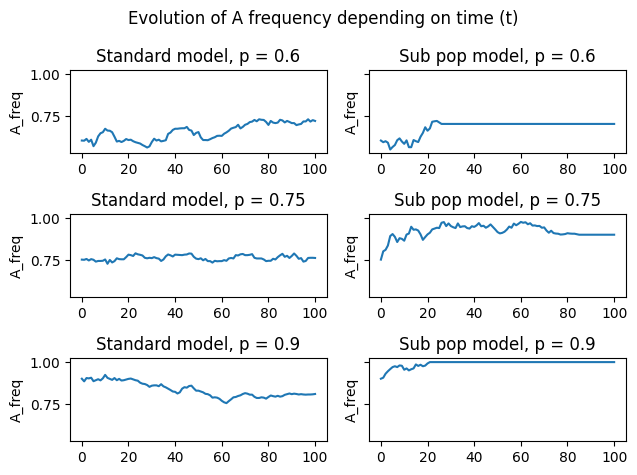

In [219]:

model_sub_pop = PopulationModel(N=100, t=100, p=0.8, m=0.1, nb_sub_pop=10, nb_simulations=10)
model = GeneticDriftModel(N=100, t=100, p=0.8, nb_simulations=10)

f, axes = plt.subplots(3, 2, sharey=True)
p_values = [0.6, 0.75, 0.9]

for p, ax in tqdm(zip(p_values, axes)):
    sp1, sp2 = ax
    model.update_p(p)
    model_sub_pop.update_p(p)
    _, _, (avg_A_freq, avg_B_freq) = model.estimate_simulation_parameters()
    _, _, (avg_A_freq_sp, avg_B_freq_sp) = model_sub_pop.estimate_simulation_parameters()

    sp1.plot(avg_A_freq)
    sp2.plot(avg_A_freq_sp)
    sp1.set_ylabel("A_freq")
    sp2.set_ylabel("A_freq")
    sp1.set_title(f"Standard model, p = {model.p}")
    sp2.set_title(f"Sub pop model, p = {model_sub_pop.p}")
f.suptitle("Evolution of A frequency depending on time (t)")
f.tight_layout()


In [302]:
model_sub_pop = PopulationModel(N=13, t=3, p=0.8, m=0.5, nb_sub_pop=3, nb_simulations=50)
model_sub_pop.genetic_drift_simulation()

Pop size changed from 13 to 12 for simulation purposes
3 1
['A' 'A' 'A' 'B']
[array(['A', 'B', 'A', 'A'], dtype='<U1'), array(['B', 'A', 'A', 'A'], dtype='<U1'), array(['A', 'A', 'B', 'A'], dtype='<U1')]
Generation 0


Pop before subpop 0 migrates towards
[array(['A', 'B', 'A', 'A'], dtype='<U1'), array(['B', 'A', 'A', 'A'], dtype='<U1'), array(['A', 'A', 'B', 'A'], dtype='<U1')]
[array(['A', 'B', 'A', 'A'], dtype='<U1'), array(['B', 'A', 'A', 'A'], dtype='<U1'), array(['A', 'A', 'B', 'A'], dtype='<U1')]
Pop after subpop 0 migrates towards subpop 2, with alleles index [1 3]
[array(['A', 'B', 'A', 'A'], dtype='<U1'), array(['B', 'A', 'A', 'A'], dtype='<U1'), array(['A', 'B', 'B', 'A'], dtype='<U1')]
[array(['A', 'B', 'A', 'A'], dtype='<U1'), array(['B', 'A', 'A', 'A'], dtype='<U1'), array(['A', 'A', 'B', 'A'], dtype='<U1')]

Pop before subpop 1 migrates towards
[array(['A', 'B', 'A', 'A'], dtype='<U1'), array(['B', 'A', 'A', 'A'], dtype='<U1'), array(['A', 'B', 'B', 'A'], dtype='<U1')]


([0.8, 0.5833333333333334, 0.75, 0.6666666666666666],
 [0.19999999999999996, 0.41666666666666663, 0.25, 0.33333333333333337])

In [249]:
a = ['A', 'A', 'B', 'B']
random.shuffle(a)
a

['B', 'A', 'A', 'B']